In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as stats 
import numpy as np
import os 

# Functions 

In [2]:
# df input should be merged df - both video and bw data 

def print_video_counts(df):
    # number of zeno videos and participants included 
    print('total videos - df length: ' + 
          str(len(df))) 

    print('unique demographic_diagnosis in df: ' + 
         str(pd.unique(df['demographic_diagnosis'])))
    
    print('num videos with demographic_diagnosis == HC: ' + 
         str(len(df[df['demographic_diagnosis'] == 'HC']))) 

    print('num videos demographic_diagnosis == MS: ' + 
         str(len(df[df['demographic_diagnosis'] == 'MS']))) 

    print('------')

    print('unique id_video (participants) in df: ' + 
          str(len(pd.unique(df['id_video'])))) 

    print('num participants with demographic_diagnosis == HC: ' + 
         str(len(pd.unique(df['id_video'][df['demographic_diagnosis'] == 'HC'])))) 
    
    print('num participants demographic_diagnosis == MS: ' + 
         str(len(pd.unique(df['id_video'][df['demographic_diagnosis'] == 'MS']))))

    print('------') 
    
    print('number of participants with multiple videos in dataset: ' + 
         str(df['id_video'][df['id_video'].duplicated()].nunique()))

    print('number of participants with one video: ' + 
          str((df['id_video'].value_counts() == 1).sum()))

In [3]:
# correlation of same metrics from difference data sources (left vs right videos)

def metric_correlation_rl(df, left_columns, right_columns, output_folder_path): 
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)
    
    # create empty list to store results 
    corr_results_all = [] 
    clean_df = pd.DataFrame() 
    
    for metric_i, current_metric in enumerate(left_columns): 
        current_left_col = left_columns[metric_i]
        current_right_col = right_columns[metric_i]

        # Drop rows with NaN values in either column - required to run spearman r 
        clean_df = df.dropna(subset=[current_left_col, current_right_col])
        
        # plot 
        sns.lmplot(x = current_right_col, y = current_left_col, data = clean_df, ci = None)
        # Set the x and y axis limits to the same range
        # plt.axis('square')  
       # min_val = min(clean_df[current_left_col].min(), clean_df[current_left_col].min())  
       # max_val = max(clean_df[current_left_col].max(), clean_df[current_left_col].max())  
       # plt.xlim(min_val, max_val)
       # plt.ylim(min_val, max_val) 
        plt.savefig(os.path.join(output_folder_path, str(current_left_col) +  '_.png'))
        plt.close()

        # run spearman correlation and append   
        statistic, p_value = stats.spearmanr(clean_df[current_right_col], clean_df[current_left_col])
        corr_results_all.append({'bw_column': current_right_col, 
                                 'video_column': current_left_col, 
                                 'corr_method': 'spearman', 
                                 'rs': statistic, 
                                 'p_value' : p_value,
                                 'n observations': len(clean_df)})

    # Create DataFrame with results
    corr_results_df = pd.DataFrame(corr_results_all)
    corr_results_df = corr_results_df.round(3)

    return corr_results_df
    

In [4]:
# use same columns as metric correlations 
def calculate_metric_mean_diff(df, left_columns, right_columns, output_folder_path):
    # one dot = participant 

    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path) 
        
    mean_error_all = [] 

    for metric_i, current_metric in enumerate(left_columns): 
        current_left_col = left_columns[metric_i]
        current_right_col = right_columns[metric_i]

        # Drop rows with NaN values in either column 
        clean_df = df.dropna(subset=[current_left_col, current_right_col])

        current_metric_diff = clean_df[current_right_col] - clean_df[current_left_col]
        current_mean_diff = current_metric_diff.mean()
        current_abs_mean_diff = abs(current_metric_diff).mean()

        # calculate mean ground truth data 
        rl_mean = clean_df[[current_left_col, current_right_col]].mean().mean()
        mean_err_per = (current_mean_diff / rl_mean) * 100 
        mae_per = (current_abs_mean_diff / rl_mean) * 100 

        # plot 
        fig, ax1 = plt.subplots()
        sns.boxplot(y=current_metric_diff, ax=ax1, fill = False, dodge = True, fliersize = 0)
        sns.stripplot(y = current_metric_diff, ax = ax1, color = 'black', dodge = True)
        fig.suptitle('Right - Left Video')
        ax1.set_title(current_right_col)
        # center plot at zero
        ymin, ymax = plt.ylim()
        plt.ylim(min(ymin, -ymax), max(ymax, -ymin))
        plt.ylabel('Error')

        # add line at zero
        plt.axhline(y=0, color='grey', linestyle='--')
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder_path, str(current_left_col + '_diff_box.png')))
        plt.close()

        # mean difference 
        mean_error_all.append({'right_col': current_right_col, 
                               'left_col': current_left_col,
                               'n' : len(clean_df), 
                               'mean_all_l_and_r_metrics' : rl_mean,
                               'mean_difference': current_mean_diff, 
                               'mean_abs_difference' : current_abs_mean_diff, 
                               'mean_diff_%_of_mean' : mean_err_per,
                               'mean_abs_diff_%_of_mean' : mae_per})

    
     # Create DataFrame with results
    mean_error_df = pd.DataFrame(mean_error_all)
    mean_error_df = mean_error_df.round(3)
    
    return mean_error_df

In [5]:
# use same columns as metric correlation 

def bland_altman_plot(df, left_columns, right_columns, output_folder_path):
     
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    for metric_i, current_metric in enumerate(left_columns): 
        current_right_col = right_columns[metric_i]
        current_left_col = left_columns[metric_i]

        clean_df = df.dropna(subset=[current_left_col, current_right_col])
    
        # Compute the mean and the difference
        mean_measurements = (clean_df[current_right_col] + clean_df[current_left_col]) / 2
        diff_measurements = clean_df[current_right_col] - clean_df[current_left_col]  # Difference between measurements

        # Mean difference and standard deviation of the difference
        mean_diff = np.mean(diff_measurements)
        std_diff = np.std(diff_measurements)

        # Plot the data
        plt.figure(figsize=(8, 6))
        plt.scatter(mean_measurements, diff_measurements, alpha=0.5)
    
        # Add mean difference line and limits of agreement (±1.96*std)
        plt.axhline(mean_diff, color='black', linestyle='--', label=f'Mean diff: {mean_diff:.2f}')
        plt.axhline(mean_diff + 1.96 * std_diff, color='red', linestyle='--', label=f'+1.96 SD: {mean_diff + 1.96 * std_diff:.2f}')
        plt.axhline(mean_diff - 1.96 * std_diff, color='blue', linestyle='--', label=f'-1.96 SD: {mean_diff - 1.96 * std_diff:.2f}')
        plt.axhline(y=0, color='grey', linestyle='--')
    
        # Labels and title
        plt.xlabel('Mean of Right and Left Turns Video Metric') 
        plt.ylabel('Right Video - Left Video Metric')
        plt.suptitle('Right vs Left')
        plt.title(current_right_col)
        plt.legend()
        plt.savefig(os.path.join(output_folder_path,  str(current_left_col + '_blandalt.png')))
        plt.close()

In [6]:
# merge home video data with preferred walking speed mat data 
# participants walk at preferred pace at home 

def merge_bw_hv(bw_df, hv_df, out_path):
    # filter bw ids dataset to only those included in video data set 
    hv_in_bw_df = bw_df[bw_df['bw_id'].isin(hv_df['bw_id'])]
   # hv_in_bw_df.to_csv(os.path.join(out_path, 'hv_id_in_bw_df.csv')) # save excel 

    print('total bw rows with id in video dataset') 
    print(len(hv_in_bw_df))

    # Track used rows from zv_in_bw_df
    used_indices = set()

    # Helper function to find the closest date
    def find_closest_date_unique(row, in_bw_df):
        # Filter rows with the same 'bw_id' and not already used
        filtered_df = in_bw_df[(in_bw_df['bw_id'] == row['bw_id'])] 
        if filtered_df.empty:
            return None
        
        # Find the closest date
        closest_idx = (filtered_df['visit_date'] - row['video_date']).abs().idxmin()
        # used_indices.add(closest_idx)  # Mark the row as used
        return filtered_df.loc[closest_idx]

    # Apply the helper function row-wise
    closest_rows = hv_df.apply(
        lambda row: find_closest_date_unique(row, hv_in_bw_df), axis=1
    )


    # Merge the original `hv df` with `closest_rows_df`
    merged_bw_hv_df = hv_df.merge(closest_rows, left_index=True, right_index=True, suffixes=('', '_closest'))

    # add column for date diff 
    merged_bw_hv_df['bw_hv_abs_date_diff'] = abs(merged_bw_hv_df['visit_date'] - merged_bw_hv_df['video_date'])
    
    # check same ID for each row 
    print('mismatched home video vs brainwalk id')
    print(sum(merged_bw_hv_df['bw_id'] != merged_bw_hv_df['bw_id']))
    
    return merged_bw_hv_df

# Load and Format Data 

In [7]:
# version 
version = '004' 

In [8]:
# output folder 
output_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis', 
                           version, 
                           'home_feasibility_reliability') 
                           
if not os.path.exists(output_path):
        os.makedirs(output_path)

In [9]:
# created in analysis_video_vs_mat_and_outcomes script, need to run that script first  
bw_hv_pws_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis',
                              version, 
                              'hv_bw_merged.csv') 
bw_hv_pws_df = pd.read_csv(bw_hv_pws_path, index_col = 0)

In [10]:
# vids included in analysis 
included_vids_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code', 
                                  'gait_bw_home_outputs_' + version, 
                                  'gait_bw_home_outputs_' + version + '_included_videos.csv') 
included_vids = pd.read_csv(included_vids_path, index_col = 0)

In [11]:
# BW long, demographic data only 
bw_df = pd.read_excel(r'C:\Users\mmccu\AppData\Local\Temp\ccsecure\2024_10_15_BrainWalk_AllData_Long_MM.xlsx', 
                     index_col = None, 
                     usecols = ['bw_id', 'record_id', 'visit_date', 'demoEHR_DiseaseDuration',
                                'demoEHR_GENDER', 'demoEHR_Age', 'demographic_diagnosis', 'bingoEHR_DX_MS DX', 'demoEHR_REC_1',	
                                'demoEHR_REC_2', 'bingoEHR_EDSS_measure_value', 'msfcEHR_T25FW SPEED AVG']) 

bw_df_ms = bw_df.loc[bw_df['demographic_diagnosis'] == 'MS', :]

In [12]:
# add columns for ordinal EDSS severity and t25fw 
bw_hv_pws_df['edss_severity_cat'] = pd.Categorical(bw_hv_pws_df['edss_severity_cat'], categories=["mild", "moderate", "severe"], ordered=True)
bw_hv_pws_df['t25fw_group_cat'] = pd.Categorical(bw_hv_pws_df['t25fw_group_cat'], categories=["under_6", "6_to_8", "over_8"], ordered=True)

In [13]:
# select only video columns 
hv_subset_cols =  [col for col in bw_hv_pws_df.columns if col.endswith('hv')] 
hv_subset_df = bw_hv_pws_df.loc[:, hv_subset_cols]

# make one row per date and id combo - one row with both left and right video 
hv_subset_wide_df = hv_subset_df.pivot(index='id_date_pose_hv', columns='task_pose_hv').reset_index()
hv_subset_wide_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in hv_subset_wide_df.columns]
hv_subset_wide_df = hv_subset_wide_df.drop(['video_id_date_name_pose_hv_gait_vertical_left', 'video_id_date_name_pose_hv_gait_vertical_right', 
                                            'walk_segment_pose_hv_gait_vertical_left', 'walk_segment_pose_hv_gait_vertical_right',
                                            'foot1_pose_hv_gait_vertical_left', 'foot1_pose_hv_gait_vertical_right'],
                                          axis = 1)
hv_subset_wide_df.head()
hv_subset_wide_df.to_csv(os.path.join(output_path, 'hv_metrics_only_wide.csv'))

In [14]:
left_hv_colnames = [col for col in hv_subset_wide_df.columns if col.endswith('left')] 
right_hv_colnames = [col for col in hv_subset_wide_df.columns if col.endswith('right')] 

In [15]:
# double check if using this script - left and right are ordered the same 
    # first right metric is same as first left metric 

for colname_i, current_metric in enumerate(left_hv_colnames): 
    print(left_hv_colnames[colname_i])
    print(right_hv_colnames[colname_i])
    print('------------')

total_video_duration_sec_pose_hv_gait_vertical_left
total_video_duration_sec_pose_hv_gait_vertical_right
------------
walking_segmets_n_pose_hv_gait_vertical_left
walking_segmets_n_pose_hv_gait_vertical_right
------------
walking_segments_duration_mean_pose_hv_gait_vertical_left
walking_segments_duration_mean_pose_hv_gait_vertical_right
------------
walking_segments_duration_median_pose_hv_gait_vertical_left
walking_segments_duration_median_pose_hv_gait_vertical_right
------------
stride_time_mean_sec_pose_hv_gait_vertical_left
stride_time_mean_sec_pose_hv_gait_vertical_right
------------
stride_time_median_sec_pose_hv_gait_vertical_left
stride_time_median_sec_pose_hv_gait_vertical_right
------------
stride_time_std_pose_hv_gait_vertical_left
stride_time_std_pose_hv_gait_vertical_right
------------
stride_time_cv_pose_hv_gait_vertical_left
stride_time_cv_pose_hv_gait_vertical_right
------------
stride_time_max_pose_hv_gait_vertical_left
stride_time_max_pose_hv_gait_vertical_right
-----

## Test-Retest Reliability 
- how similar are metrics sent by same person on the same day 

In [16]:
# Pearson R correlation for each metric 
corr_out_path1 = os.path.join(output_path, 'test_retest', 'right_vs_left_metric_correlation')

hv_lr_corr_results_df = metric_correlation_rl(hv_subset_wide_df, left_hv_colnames, right_hv_colnames, corr_out_path1)
hv_lr_corr_results_df.to_csv(os.path.join(corr_out_path1, 'correlation_results_rl.csv'))

In [17]:
# Mean Difference and Mean Absolute Difference Right vs Left 
mean_diff_path = os.path.join(output_path, 'test_retest', 'diff_right_vs_left')
mean_diff_df = calculate_metric_mean_diff(hv_subset_wide_df, left_hv_colnames, right_hv_colnames, mean_diff_path)
mean_diff_df.to_csv(os.path.join(mean_diff_path, 'right_left_diff_results_rl.csv'))

In [18]:
# bland altman 
ba_path = os.path.join(output_path, 'test_retest', 'right_vs_left_metric_blandalt')
bland_altman_plot(hv_subset_wide_df, left_hv_colnames, right_hv_colnames, ba_path)

In [19]:
# ICC ? not sure if another measure is more appropriate 

## Feasibility
- compare demographics between groups
- 12/20/24 - just comparing ppl who sent videos vs usable videos
- 
- To - do: check in with coordinators to confirm list of consented people is correct
   - once confirmed - can do 1) all MS participants vs those who consented AND 2) all people who consented vs those who actually sent videos 

In [20]:
# feasibility outpath 
feas_outpath = os.path.join(output_path, 'feasibility')
if not os.path.exists(feas_outpath):
    os.makedirs(feas_outpath)

### All videos sent VS Videos included in analysis 

In [21]:
# get BW-ID and date for all gait_vertical_videos 
# start fom original pose, save .csv
home_video_folder_path = r'C:\Users\mmccu\Box\Brainwalk\Home Video Walking\Walking home videos for analysis'

ALLOWED_VID_FORMATS = ["asf", "avi", "gif", "m4v",
                       "mkv", "mov", "mp4", "mpeg",
                       "mpg", "ts", "wmv", "webm"]


# loop through all files in input path 
video_files_all = []
for (dir_path, dir_names, file_names) in os.walk(home_video_folder_path):
    for file_name in file_names: 
        name, ext = os.path.splitext(file_name)
        ext = ext.lower()[1:]
        current_raw_data_in_path = os.path.join(dir_path, file_name) # full path to files 
        # save full path to file if it meets requirements to run in analysis 
        if (ext in ALLOWED_VID_FORMATS) & ('gait_vertical' in name): 
            parent1, date = os.path.split(dir_path)
            parent2, bw_id = os.path.split(parent1)
            video_files_all.append((name, date, bw_id))

video_files_all_df = pd.DataFrame(video_files_all,  columns = ['file_name', 'video_date', 'bw_id']) 

In [22]:
len(video_files_all_df)

76

In [23]:
# format date of all videos 
video_files_all_df['video_date'] = pd.to_datetime(video_files_all_df['video_date'], errors = 'coerce')

C:\Users\mmccu\AppData\Local\Temp\ipykernel_24636\1440050990.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  video_files_all_df['video_date'] = pd.to_datetime(video_files_all_df['video_date'], errors = 'coerce')


In [24]:
# manually set video num column in all videos df 
    # 1 = first date videos were sent by that participant (could be multiple videos but first set of videos), 2 = second set of videos sent, etc 
    ## NEED TO REDO MANUALLY IF VIDEO ORDER CHANGES 

video_files_all_df['video_set_num'] = 1

row_video_set_num2 = [4,5, 23, 24, 50, 51, 54, 55]
video_files_all_df.iloc[row_video_set_num2, 3] = 2
video_files_all_df.to_csv(os.path.join(output_path, 'home_video_files_all.csv'))
video_files_all_df.head()

,file_name,video_date,bw_id,video_set_num
0,gait_vertical_left,2023-10-24,BW-0018,1
1,gait_vertical_right,2023-10-24,BW-0018,1
2,gait_vertical_left,2023-05-05,BW-0023,1
3,gait_vertical_right,2023-05-05,BW-0023,1
4,gait_vertical_left,2023-10-23,BW-0023,2


In [25]:
# merge all video files with brainwalk data 
video_files_all_w_bw_df = merge_bw_hv(bw_df_ms, video_files_all_df, output_path)
video_files_all_w_bw_df.to_csv(os.path.join(output_path, 'home_vids_all_w_bw.csv'))
print('rows (participants) in included videos')
print(len(video_files_all_w_bw_df))

total bw rows with id in video dataset
67
mismatched home video vs brainwalk id
0
rows (participants) in included videos
76


In [26]:
# format included vids df 

# add bw id and video date to zv df 
included_vids['bw_id'] = included_vids['included_vids'].str.extract(r'(BW-\d{4})')

# new idea 
included_vids['video_date'] = included_vids['included_vids'].str.replace('gait_vertical_left_', '')
included_vids['video_date'] = included_vids['video_date'].str.replace('gait_vertical_right_', '')
included_vids['video_date'] = included_vids['video_date'].str[8:]
included_vids['video_date'] = pd.to_datetime(included_vids['video_date'], errors = 'coerce')

C:\Users\mmccu\AppData\Local\Temp\ipykernel_24636\4029297912.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  included_vids['video_date'] = pd.to_datetime(included_vids['video_date'], errors = 'coerce')


In [27]:
# add video num col to included videos df using info from all videos df 
    # merge/join - video num for each id/date combo in included should match video num for the same id/date combo in all df  
print('check same length after merge') 
print(len(included_vids))
video_files_all_to_merge = video_files_all_df.drop_duplicates(subset=['bw_id', 'video_date'])
included_vids = included_vids.merge(right = video_files_all_to_merge, how = 'left', on = ['bw_id', 'video_date'])
included_vids.to_csv(os.path.join(feas_outpath, 'home_vids_included_in_analysis.csv'))
print(len(included_vids))

check same length after merge
61
61


In [28]:
# filter to only include unique combo of id, date, and video set num  
unique_video_files_all = video_files_all_df.drop_duplicates(subset=['bw_id', 'video_date', 'video_set_num'])
unique_included_vids = included_vids.drop_duplicates(subset=['bw_id', 'video_date', 'video_set_num'])

In [29]:
print(len(video_files_all_df))
print(len(unique_video_files_all))

print(len(included_vids))
print(len(unique_included_vids))

76
39
61
31


In [30]:
# participants with no videos from a set of videos incuded in analysis 
    # if they sent two videos on one day and only one was included in analysis, they are counted as "includd" 
    # if all the videos they sent on one day were excluded, they are "not_included" 

# Perform a left join to find matches
merged = unique_video_files_all.merge(
    unique_included_vids,
    on=['video_date', 'bw_id', 'video_set_num'],
    how='left',
    indicator=True
)

# Filter rows that are in df_all but not in df_included
not_included = merged[merged['_merge'] == 'left_only']

# Drop the '_merge' column to clean up
not_included = not_included.drop(columns=['_merge', 'included_vids', 'file_name_y'])


In [31]:
# merge unique_included_vids w bw demographic data 
included_vids_w_bw = merge_bw_hv(bw_df_ms, unique_included_vids, output_path)
included_vids_w_bw.to_csv(os.path.join(output_path, 'home_vids_included_in_analysis_w_bw.csv'))
print('rows (participants) in included videos')
print(len(included_vids_w_bw))

total bw rows with id in video dataset
51
mismatched home video vs brainwalk id
0
rows (participants) in included videos
31


In [32]:
# merge not_included w bw demographic data 
exluded_vids_w_bw = merge_bw_hv(bw_df_ms, not_included, output_path)
exluded_vids_w_bw.to_csv(os.path.join(output_path, 'home_vids_excluded_from_analysis_w_bw.csv'))
print('rows (participants) in excluded videos')
print(len(exluded_vids_w_bw))

total bw rows with id in video dataset
16
mismatched home video vs brainwalk id
0
rows (participants) in excluded videos
8


### compare demographics between included and excluded
- TBD on scripts below, may need to fix 

In [33]:
included_vids_w_bw.columns

Index(['included_vids', 'bw_id', 'video_date', 'file_name', 'video_set_num',
       'bw_id_closest', 'record_id', 'visit_date', 'demoEHR_DiseaseDuration',
       'demoEHR_GENDER', 'demoEHR_Age', 'bingoEHR_DX_MS DX', 'demoEHR_REC_1',
       'demoEHR_REC_2', 'bingoEHR_EDSS_measure_value',
       'msfcEHR_T25FW SPEED AVG', 'demographic_diagnosis',
       'bw_hv_abs_date_diff'],
      dtype='object')

In [34]:
def test_distribution_var(group1_data, group2_data): 
    # Test normally distributed  
    inc_shapiro_stat, inc_shapiro_p = stats.shapiro(group1_data)
    print('group 1 distribution') 
    print(round(inc_shapiro_p, 3))
    if inc_shapiro_p > 0.05:
        print("Data looks normally distributed (fail to reject H0)")
    else:
        print("Data does not look normally distributed (reject H0)")


    exc_shapiro_stat, exc_shapiro_p = stats.shapiro(group2_data)
    print('group 2 distribution') 
    print(round(exc_shapiro_p, 3))
    if exc_shapiro_p > 0.05:
        print("Data looks normally distributed (fail to reject H0)")
    else:
        print("Data does not look normally distributed (reject H0)")


    # test similar variance 
    print('test similar variance')
    statistic, sd_p_value = stats.levene(group1_data, group2_data) 
    print(sd_p_value)
    if sd_p_value > 0.05:
        print("Fail to reject the null hypothesis: Variances are equal.")
    else:
        print("Reject the null hypothesis: Variances are not equal.")

group 1 distribution
0.014
Data does not look normally distributed (reject H0)
group 2 distribution
0.715
Data looks normally distributed (fail to reject H0)
test similar variance
0.7964411302767618
Fail to reject the null hypothesis: Variances are equal.
t-test p val
0.9583379334468081
Fail to reject the null hypothesis: Means are equal.


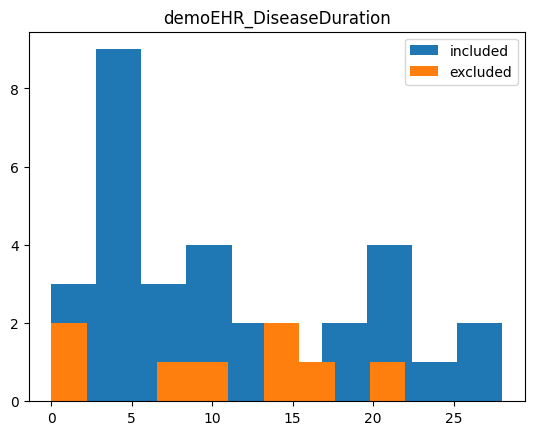

In [35]:
# demoEHR_DiseaseDuration    
    # continous - compare of two groups means, unpaired -> t-test 


test_distribution_var(group1_data = included_vids_w_bw['demoEHR_DiseaseDuration'], 
                      group2_data = exluded_vids_w_bw['demoEHR_DiseaseDuration'])

plt.hist(included_vids_w_bw['demoEHR_DiseaseDuration'], label = 'included') 
plt.hist(exluded_vids_w_bw['demoEHR_DiseaseDuration'], label = 'excluded')
plt.title('demoEHR_DiseaseDuration')
plt.legend()


# t-test 
print('t-test p val')
manwhit_stat_dur, manwhit_p_dur = stats.mannwhitneyu(included_vids_w_bw['demoEHR_DiseaseDuration'], exluded_vids_w_bw['demoEHR_DiseaseDuration'])
print(manwhit_p_dur)
if manwhit_p_dur > 0.05:
    print("Fail to reject the null hypothesis: Means are equal.")
else:
    print("Reject the null hypothesis: Means are not equal.")

group 1 distribution
0.028
Data does not look normally distributed (reject H0)
group 2 distribution
0.411
Data looks normally distributed (fail to reject H0)
test similar variance
0.014987160616430217
Reject the null hypothesis: Variances are not equal.
t-test p val
0.7278152379582001
Fail to reject the null hypothesis: Means are equal.


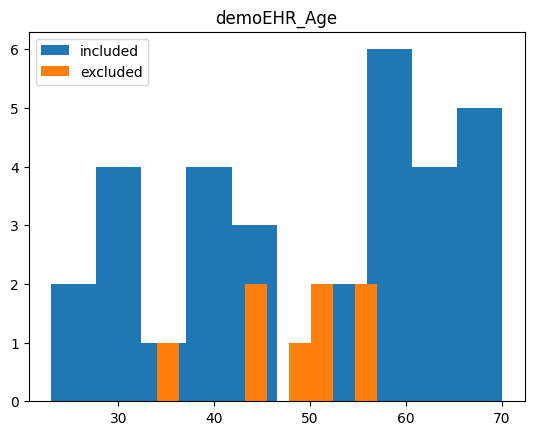

In [36]:
# demoEHR_Age - continous, unpaired, t-test 
test_distribution_var(group1_data = included_vids_w_bw['demoEHR_Age'], 
                      group2_data = exluded_vids_w_bw['demoEHR_Age'])

plt.hist(included_vids_w_bw['demoEHR_Age'], label = 'included') 
plt.hist(exluded_vids_w_bw['demoEHR_Age'], label = 'excluded')
plt.title('demoEHR_Age')
plt.legend()


# t-test 
print('t-test p val')
manwhit_stat_age, manwhit_p_value_age = stats.mannwhitneyu(included_vids_w_bw['demoEHR_Age'], exluded_vids_w_bw['demoEHR_Age'])
print(manwhit_p_value_age)
if manwhit_p_value_age > 0.05:
    print("Fail to reject the null hypothesis: Means are equal.")
else:
    print("Reject the null hypothesis: Means are not equal.")

group 1 distribution
nan
Data does not look normally distributed (reject H0)
group 2 distribution
0.0
Data does not look normally distributed (reject H0)
test similar variance
nan
Reject the null hypothesis: Variances are not equal.
mann whitney u test p value
0.49443820268254357
Fail to reject the null hypothesis: Means are equal.


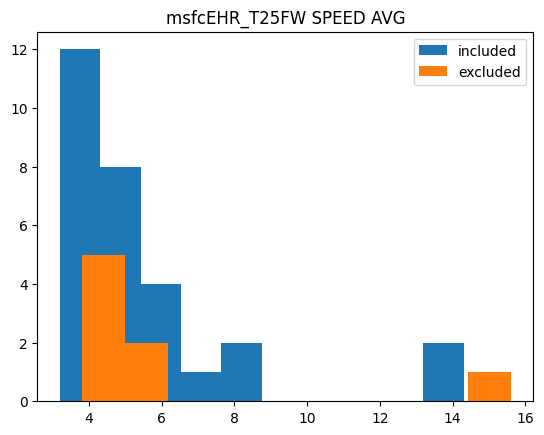

In [37]:
# msfcEHR_T25FW SPEED AVG      
    # continuous - t test 
test_distribution_var(group1_data = included_vids_w_bw['msfcEHR_T25FW SPEED AVG'], 
                      group2_data = exluded_vids_w_bw['msfcEHR_T25FW SPEED AVG'])

plt.hist(included_vids_w_bw['msfcEHR_T25FW SPEED AVG'], label = 'included') 
plt.hist(exluded_vids_w_bw['msfcEHR_T25FW SPEED AVG'], label = 'excluded')
plt.title('msfcEHR_T25FW SPEED AVG')
plt.legend()

# man whitney u - no normal 
print('mann whitney u test p value')
man_stat_t25fw, manw_pvalue_t25fw = stats.mannwhitneyu(included_vids_w_bw['msfcEHR_T25FW SPEED AVG'], exluded_vids_w_bw['msfcEHR_T25FW SPEED AVG'],
                                          nan_policy='omit') 
print(manw_pvalue_t25fw)
if manw_pvalue_t25fw > 0.05:
    print("Fail to reject the null hypothesis: Means are equal.")
else:
    print("Reject the null hypothesis: Means are not equal.")

### confirm if right test below? 

group 1 distribution
nan
Data does not look normally distributed (reject H0)
group 2 distribution
0.932
Data looks normally distributed (fail to reject H0)
test similar variance
nan
Reject the null hypothesis: Variances are not equal.
mann whitney u test p value
0.8708758788060971
Fail to reject the null hypothesis: Means are equal.


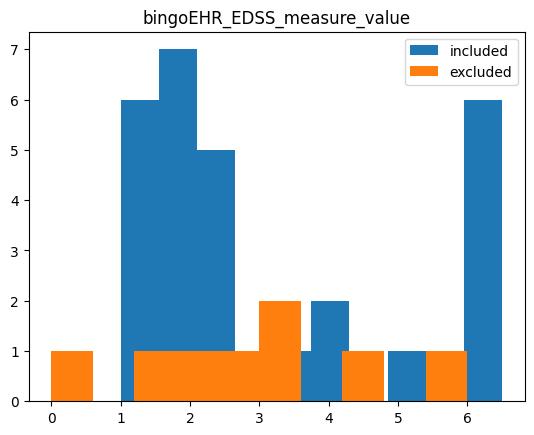

In [38]:
# bingoEHR_EDSS_measure_value   
test_distribution_var(group1_data = included_vids_w_bw['bingoEHR_EDSS_measure_value'], 
                      group2_data = exluded_vids_w_bw['bingoEHR_EDSS_measure_value'])

plt.hist(included_vids_w_bw['bingoEHR_EDSS_measure_value'], label = 'included') 
plt.hist(exluded_vids_w_bw['bingoEHR_EDSS_measure_value'], label = 'excluded')
plt.title('bingoEHR_EDSS_measure_value')
plt.legend()

# Mann whitney u test ? 
# man whitney u - no normal 
print('mann whitney u test p value')
man_stat_edss, manw_pvalue_edss = stats.mannwhitneyu(included_vids_w_bw['bingoEHR_EDSS_measure_value'], exluded_vids_w_bw['bingoEHR_EDSS_measure_value'],
                                          nan_policy='omit') 
print(manw_pvalue_edss)
if manw_pvalue_edss > 0.05:
    print("Fail to reject the null hypothesis: Means are equal.")
else:
    print("Reject the null hypothesis: Means are not equal.")

In [39]:
def check_freq_table(group1_data, group2_data): 
    value_counts_df1 = group1_data.value_counts()
    value_counts_df2 = group2_data.value_counts()

    # Create a contingency table
    print('For chi-squared: expected counts should not be less than 2') 
    print('or no more than 20% of expected values should be less than 5') 
    print('if assumption not met - use Fishers exact test') 
    contingency_table = pd.DataFrame({
        'DF1': value_counts_df1,
        'DF2': value_counts_df2
    }).fillna(0)  
    print(contingency_table)

    return contingency_table

In [40]:
# demoEHR_GENDER     
    # chi squared - two cateogrical aoutcomes 

contingency_table = check_freq_table(group1_data = included_vids_w_bw['demoEHR_GENDER'], 
                                     group2_data = exluded_vids_w_bw['demoEHR_GENDER'])


# Perform chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Display results
print("Chi-squared Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:\n", expected)

For chi-squared: expected counts should not be less than 2
or no more than 20% of expected values should be less than 5
if assumption not met - use Fishers exact test
                DF1  DF2
demoEHR_GENDER          
Female           26    7
Male              5    1
Chi-squared Statistic: 0.0
p-value: 1.0
Degrees of Freedom: 1
Expected Frequencies:
 [[26.23076923  6.76923077]
 [ 4.76923077  1.23076923]]


### cofirm appropriate test with such small sample size?

In [41]:
# bingoEHR_DX_MS DX
contingency_table2 = check_freq_table(group1_data = included_vids_w_bw['bingoEHR_DX_MS DX'], 
                                     group2_data = exluded_vids_w_bw['bingoEHR_DX_MS DX'])

# Perform chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table2)

# Display results
print("Chi-squared Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:\n", expected)

For chi-squared: expected counts should not be less than 2
or no more than 20% of expected values should be less than 5
if assumption not met - use Fishers exact test
                                                 DF1  DF2
bingoEHR_DX_MS DX                                        
MS, Subtype Not Specified                          2  0.0
PPMS (Primary-progressive Multiple Sclerosis)      3  1.0
RRMS (Relapsing-remitting Multiple Sclerosis)     25  7.0
SPMS (Secondary-progressive Multiple Sclerosis)    1  0.0
Chi-squared Statistic: 0.8600050403225807
p-value: 0.8350671781608556
Degrees of Freedom: 3
Expected Frequencies:
 [[ 1.58974359  0.41025641]
 [ 3.17948718  0.82051282]
 [25.43589744  6.56410256]
 [ 0.79487179  0.20512821]]


In [42]:
# demoEHR_REC_1
contingency_table3 = check_freq_table(group1_data = included_vids_w_bw['demoEHR_REC_1'], 
                                     group2_data = exluded_vids_w_bw['demoEHR_REC_1'])

# Perform chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table3)

# Display results
print("Chi-squared Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:\n", expected)

For chi-squared: expected counts should not be less than 2
or no more than 20% of expected values should be less than 5
if assumption not met - use Fishers exact test
                       DF1  DF2
demoEHR_REC_1                  
BlackHispanic            1  1.0
Other/Decline/Unknown    6  0.0
WhiteAsian              24  7.0
Chi-squared Statistic: 2.696214880332987
p-value: 0.25973135291458677
Degrees of Freedom: 2
Expected Frequencies:
 [[ 1.58974359  0.41025641]
 [ 4.76923077  1.23076923]
 [24.64102564  6.35897436]]


In [43]:
# demoEHR_REC_2 
contingency_table4 = check_freq_table(group1_data = included_vids_w_bw['demoEHR_REC_2'], 
                                     group2_data = exluded_vids_w_bw['demoEHR_REC_2'])

# Perform chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table4)

# Display results
print("Chi-squared Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:\n", expected)

For chi-squared: expected counts should not be less than 2
or no more than 20% of expected values should be less than 5
if assumption not met - use Fishers exact test
                                       DF1  DF2
demoEHR_REC_2                                  
Asian/PacificIslander/NativeAmerican   2.0  1.0
Black                                  0.0  1.0
Hispanic                               1.0  0.0
Other/Decline/Unknown                  6.0  0.0
WhiteNonHispanic                      22.0  6.0
Chi-squared Statistic: 5.998271889400923
p-value: 0.19927736698822898
Degrees of Freedom: 4
Expected Frequencies:
 [[ 2.38461538  0.61538462]
 [ 0.79487179  0.20512821]
 [ 0.79487179  0.20512821]
 [ 4.76923077  1.23076923]
 [22.25641026  5.74358974]]


## for below - see demographics table scripts to load consented and all bw data 

In [44]:
error, think demographics might be better than script above for comparing each group 
check and maybe redo scripts above 

SyntaxError: invalid syntax (431249076.py, line 1)

### consented vs sent any videos 

### consented vs did not consent to home videos 
- not sure what is appropriate - not everyone approached or asked to send videos? confirm with coordinators 